# Notebook 3: Training a Neural Network for Image Classification

In this notebook, we'll train a neural network to classify images rather than two-dimensional synthetic data. We'll also take a look at the components of a typical training pipeline in PyTorch, including datasets, data loaders, and checkpointing. We'll use a new loss function to guide our network during training, and let one of PyTorch's optimizers automatically update our network's parameters using gradient descent.

The notebook is broken up as follows:

  1. [Setup](#setup)  
  2. [Data](#data)  
     2.1 [Datasets](#datasets)  
     2.2 [DataLoaders](#dataloaders)  
  3. [A Neural Network for Image Recognition](#nn)  
     3.1. [Defining the Network](#definition)  
     3.2  [Classification Loss](#loss)  
     3.3  [Picking an Optimizer: SGD](#sgd)  
     3.4. [Checkpointing](#checkpoint)  
  4. [Putting It All Together: Training Loop](#train)  
  5. [GPU Acceleration](#gpu)

## __1.__ <a name="setup">Setup</a>


Make sure the needed packages are installed and utility code is in the right place.

In [1]:
# helper code from the course repository
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
# install common pacakges used for deep learning
!cd course-deep-learning/ && pip install -r requirements.txt

fatal: destination path 'course-deep-learning' already exists and is not an empty directory.


In [3]:
import sys
#sys.path.append('/Users/yujiaxie/.pyenv/versions/3.9.4/lib/python3.9/site-packages')

In [5]:
%matplotlib inline
#%cd course-deep-learning/

import time
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

## __2.__ <a name="data">Data</a>

### __2.1__ <a name="datasets">Datasets</a>

In the previous two notebooks, we saw a variety of two-dimensional synthetic datasets. In this notebook, we'll be working with a pre-existing image dataset. Image data is inherently high-dimensional: each pixel corresponds to a single coordinate/dimension (grayscale), or holds three separate coordinates (Red,Green,Blue). For even small images, this means our inputs can have thousands of dimensions (e.g. 32 x 32 pixels x 3 colors = 3072). As a result, image datasets can be fairly large. Additionally, we may need to apply certain __transformations__ or __preprocessing__ steps to our image data before attempting to pass it to a neural network.

PyTorch and its corresponding image library, TorchVision, offer a number of utilities to streamline dataset storage, loading, and preprocessing. We'll start by using TorchVision to download the well-known [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This dataset contains 28x28-pixel images of handwritten digits, and our goal will be to predict the correct label given an image:

In [6]:
# make a new directory in which to download the MNIST dataset
data_dir = "./data/"

# download MNIST "test" dataset
mnist_test = torchvision.datasets.MNIST(data_dir, train=False, download=True)

# download MNIST "train" dataset and set aside a portion for validation
mnist_train_full = datasets.MNIST(data_dir, train=True, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 5000])

type(mnist_test), type(mnist_train), type(mnist_val)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(torchvision.datasets.mnist.MNIST,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset)

Our dataset is now held in three `torch.utils.data.Dataset` objects, each acting as an iterable container from which we can fetch input-label pairs. You should also now see a `data/` directory containing the MNIST dataset. Let's have a look at a random image from the test set.

There are 10000 images in mnist_test
Image 4346 is a 6


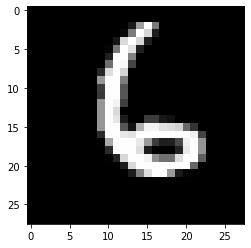

In [7]:
print(f"There are {len(mnist_test)} images in mnist_test")
d = np.random.randint(0, len(mnist_test))
print(f"Image {d} is a {mnist_test[d][1]}")

# plot our image
plt.imshow(mnist_test[d][0], cmap='gray')
plt.show()

Our "test" dataset contains 10,000 entries, each of which is a tuple holding a `PIL.Image.Image` object and an integer label. Unfortunately, the neural networks we trained in the previous notebook require `torch.Tensor` inputs. We therefore need to apply some preprocessing to these image datasets before we can train a network.

TorchVision provides a `Transform` class for building and composing preprocessing stages that can be automatically applied to your image data. Here's an example:

Image label: 7
Transformed image shape: torch.Size([1, 28, 28])
Transformed image data: 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  ...


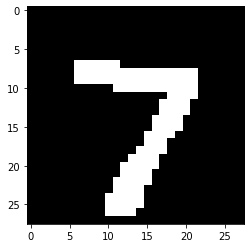

In [8]:
# we'll stack multiple transformations in a single object that will apply them in sequence
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # this is a built-in Transform object to convert images to tensors
    lambda x: x>0,  # this is our own transformation function for binarizing MNIST images
    lambda x: x.float(),  # this is our own transformation function for converting inputs to floating-point
])

# grab the first image-label pair from our "test" dataset
example_img, example_label = mnist_test[0]

# apply our sequence of transformations
transformed = transform(example_img)
print(f"Image label: {example_label}")
print("Transformed image shape:", transformed.shape)
print(f"Transformed image data: {(', '.join(str(p.item()) for p in transformed.flatten()))[:100]} ...")

# plot our image
plt.imshow(transformed.squeeze(), cmap='gray')
plt.show()

We can see that our transform converts MNIST images to floating-point tensors holding binary values -- which we can feed to a neural network! In fact, we can bake our transform directly into our datasets so that it is applied automatically when we go to fetch data. To demonstrate, we'll re-initialize our datasets, this time reading directly from our `data/` folder rather than re-downloading:

In [10]:
# load MNIST "test" dataset from disk. Note we're using the transform defined a few cells earlier, which
# turns the data into the right format as we load from disk.
mnist_test = torchvision.datasets.MNIST(data_dir, train=False, download=False, transform=transform)

# load MNIST "train" dataset from disk and set aside a portion for validation
mnist_train_full = datasets.MNIST(data_dir, train=True, download=False, transform=transform)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 5000])

example_img, example_label = mnist_test[0]
print(f"Each image in our dataset now has type {type(example_img)} and shape {example_img.shape}")

Each image in our dataset now has type <class 'torch.Tensor'> and shape torch.Size([1, 28, 28])


### __2.2__ <a name="dataloaders">DataLoaders</a>

Given that `torch.utils.data.Dataset` and its subclasses provide an iterable container from which we can fetch input-label pairs, we could go ahead and start traininng a network:

```
for x, y in myDataset:

    opt.zero_grad()

    outputs = myNetwork(x)
    
    loss = myLoss(outputs, y)
    loss.backward()
    
    opt.step()
    ...
```

However, we often want to load our data in __batches__ while training, typically in a random or __shuffled__ order. PyTorch provides a `DataLoader` class to handle the process of fetching data from a `Dataset` object, including shuffling, custom batch collation, and various random sampling schemes.

In [11]:
# we'll use a batch size of 60 for training our network
batch_size = 60

# initialize a DataLoader object for each dataset
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

# grab the first batch from one of our DataLoader objects
example_batch_img, example_batch_label = next(iter(train_dataloader))

#for batch in train_dataloader:#

#  print(batch[0], batch[1])
#  break

# inputs and labels are batched together as tensor objects
print(f"Batch inputs shape: {example_batch_img.shape}, Batch labels shape: {example_batch_label.shape}")

Batch inputs shape: torch.Size([60, 1, 28, 28]), Batch labels shape: torch.Size([60])


## __3.__ <a name="nn">A Neural Network for Image Recognition</a>

### __3.1__ <a name="definition">Defining the Network</a>

Now that we've seen the data we'll be working with, it's time build a neural network capable of classifying handwritten digits. In the previous notebook, we created a neural network capable of turning two-dimensional inputs into one-dimensional (scalar) predictions. By contrast, our inputs will have 28x28 = 784 dimensions, and our network will have to predict one of ten possible labels (one for each digit 0-9). To accommodate these changes, we'll tweak our network as follows:

   1. We'll modify our network's first layer to take 784-dimensional inputs
   2. We'll use a larger intermediate layer to allow our network to learn complex decision functions
   3. We'll try out the ReLU (rectified linear unit) activation function 
   4. We'll have our network produce a 10-dimensional vector as output; the index of the largest value in this vector will be our predicted label (e.g. if the first entry has the largest value, our predicted digit will be 0).
   
<br/>
<center>
<img width="500px" src="https://drive.google.com/uc?export=view&id=1fCIzQT6smKorQAfFmJp7GsGBC9atMo4U"/>
</center>
<br/>


In [12]:
class MNISTNetwork(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # MNIST images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Linear(28*28, 1024)
        self.layer_2 = torch.nn.Linear(1024, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):

        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)  # create an array of flattened images with dimension (batch_size, num_pixels)
        
        # this time, we'll use the ReLU nonlinearity at each layer  
        x = self.relu(self.layer_1(x))
        x = self.layer_2(x)  # we'll avoid "squashing" our final outputs by omitting the sigmoid
        
        return x

model = MNISTNetwork()
model

MNISTNetwork(
  (layer_1): Linear(in_features=784, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
)

### __3.2__ <a name="loss">Classification Loss</a>

In the previous notebook, we used mean squared error loss to train our neural network. While mean squared error performs well in a number of tasks, it is more common to use __categorical cross-entropy loss__ for multiclass classification. We can think of our network's output as a vector of ten "class scores," one per digit. In training our network, our goal is to make sure that given an input image, the correct class score "comes out on top." We might try to minimize the mean squared error between our network's normalized output and a __one-hot__ vector indexing the correct label

```
prediction = [0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.5, 0.1, 0.1]
target =     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
```

However, this objective does not necessarily correspond to our goal of maximizing the score of the target class while keeping all other scores low. Cross entropy loss generally does a better job of capturing this objective for multiclass classification, and its use can be considered equivalent to maximum-likelihood estimation under certain assumptions. We will use PyTorch's implementation, which provides an object capable of both computing the loss on pairs of tensors and computing gradients during the backward pass. We won't go into detail here, but for more info, check out the [official documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Below, we show an example of calculating loss for a bit of made-up data.



In [13]:
# a PyTorch cross-entropy loss object
loss_fn = torch.nn.CrossEntropyLoss()

# the loss object takes in a vector of class scores and a vector of target class indices
preds = torch.randn(batch_size, 10)  # make a batch of random "class score" vectors, each with 10 scores corresponding to digits
targets = torch.full((batch_size,), 7).long()  # make a batch of target indices; here, we'll set 7 as the target for all predictions

# compute the loss for this batch; by default, CrossEntropyLoss will average over a batch to return a scalar
loss_fn(preds, targets)

tensor(2.6965)

### __3.3__ <a name="sgd">Picking an Optimizer: SGD</a>

Recall that each training iteration can be broken down as follows: 
* we pass inputs to our network and collect outputs
* we compute a differentiable a scalar loss on our network's outputs
* we use backpropagation to compute the gradients of the loss with respect to our network's weights
* we perform a gradient-based update on our weights to reduce the loss 

In the previous notebook, we made use of a built-in __optimizer__ to automate the process of updating our network's weights. This optimizer object stores references to our network's weights. When our backpropagation step (`backward()`) computes and stores gradients for all network parameters, the optimizer fetches these gradients and performs an update determined by its optimization algorithm. When training neural networks with large numbers of parameters, this becomes much simpler than manually updating each weight.

PyTorch offers a number of [optimization algorithms](https://pytorch.org/docs/stable/optim.html), all of which use the same basic interface:

```
optimizer = OptimizerName(my_model.parameters(), lr=my_learning_rate, *other_params)
```

Each optimizer requires an iterable containing our network's weights (which the `.parameters()` method of any `torch.nn.Module` object provides) and a __learning rate__. As in the last notebook, we'll use __Stochastic Gradient Descent (SGD)__ to determine our updates. This algorithm scales the computed gradients with its learning rate and subtracts them from their respective weights to "descend" the loss function.

In [14]:
# a simple optimization problem: we want our "weights" to sum to 10
weights = torch.zeros(10).requires_grad_(True)
print(f"Starting weights: {weights}, Sum: {weights.sum().item()}")

# create an optimizer object and pass it an Iterable containing our "weights".
# In this example, we'll take steps of size 1.0, meaning that each weight will 
# change by an amount equal to the magnitude of its gradient
opt = torch.optim.SGD([weights], lr = 1.0)  

# compute loss and perform backpropagation
loss = 10 - weights.sum()
loss.backward()

# perform an optimization step, i.e. a gradient-based update of our weights
opt.step()

print(f"Updated weights: {weights}, Sum: {weights.sum().item()}")

Starting weights: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Sum: 0.0
Updated weights: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True), Sum: 10.0


### __3.4__ <a name="checkpoint">Checkpointing</a>

Before we begin training our model, we want to make sure we can save it in some format in case we experience a bug during training or want to use it again later. The process of saving snapshots of a model during training is often called __checkpointing__, and PyTorch offers utilities to make saving and loading models simple. For a neural network, saving a model really means saving its weights (parameters). All PyTorch models have a `.state_dict()` method that exposes their weights as named entries in a dictionary. Using this __state dictionary__, we can easily save weights or overwrite them with ones we load from elsewhere. For more info, feel free to check out the [official documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [15]:
# initialize a model
model = MNISTNetwork()
print("Names of network weights:", list(model.state_dict().keys()))

# save weights to disk
torch.save(model.state_dict(), "dummy_weights.pt")

# load weights from disk and overwrite network weights
model.load_state_dict(torch.load("dummy_weights.pt"))

model

Names of network weights: ['layer_1.weight', 'layer_1.bias', 'layer_2.weight', 'layer_2.bias']


MNISTNetwork(
  (layer_1): Linear(in_features=784, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
)

## __4.__ <a name="train">Putting It All Together: Training Loop</a>
We're now ready to train a neural network to recognize handwritten digits from the MNIST dataset.

In [16]:
def training_loop(save_path, epochs, batch_size, device="cpu"):
    """
    Train a neural network model for digit recognition on the MNIST dataset.
    
    Parameters
    ----------
    save_path (str):  path/filename for model checkpoint, e.g. 'my_model.pt'
    
    epochs (int):     number of iterations through the whole dataset for training
    
    batch_size (int): size of a single batch of inputs
    
    device (str):     device on which tensors are placed; should be 'cpu' or 'cuda'. 
                      More on this in the next section!
    
    Returns
    -------
    model (nn.Module): final trained model
    
    save_path (str):   path/filename for model checkpoint, so that we can load our model
                       later to test on unseen data
    
    device (str):      the device on which we carried out training, so we can match it
                       when we test the final model on unseen data later
    """

    # initialize model
    model = MNISTNetwork()
    model.to(device)  # we'll cover this in the next section!

    # initialize an optimizer to update our model's parameters during training
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # make a new directory in which to download the MNIST dataset
    data_dir = "./data/"
    
    # initialize a Transform object to prepare our data
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        lambda x: x>0,
        lambda x: x.float(),
    ])

    # load MNIST "test" dataset from disk
    mnist_test = torchvision.datasets.MNIST(data_dir, train=False, download=False, transform=transform)

    # load MNIST "train" dataset from disk and set aside a portion for validation
    mnist_train_full = datasets.MNIST(data_dir, train=True, download=False, transform=transform)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 5000])

    # initialize a DataLoader object for each dataset
    train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

    # a PyTorch categorical cross-entropy loss object
    loss_fn = torch.nn.CrossEntropyLoss()

    # time training process
    st = time.time()

    # time to start training!
    for epoch_idx, epoch in enumerate(range(epochs)):

        # keep track of best validation accuracy; if improved upon, save checkpoint
        best_acc = 0.0

        # loop through the entire dataset once per epoch
        train_loss = 0.0
        train_acc = 0.0
        train_total = 0
        model.train()
        for batch_idx, batch in enumerate(train_dataloader):

            # clear gradients
            optimizer.zero_grad()

            # unpack data and labels
            x, y = batch
            x = x.to(device)  # we'll cover this in the next section!
            y = y.to(device)  # we'll cover this in the next section!

            # generate predictions and compute loss
            output = model(x)  # (batch_size, 10)
            loss = loss_fn(output, y)

            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item()/len(y)

            # compute gradients and update model parameters
            loss.backward()
            optimizer.step()

            # update statistics
            train_loss += (loss * len(x))
            train_acc += (acc * len(x))
            train_total += len(x)

        train_loss /= train_total
        train_acc /= train_total

        # perform validation once per epoch
        val_loss = 0.0
        val_acc = 0.0
        val_total = 0
        model.eval()
        for batch_idx, batch in enumerate(val_dataloader):

            # don't compute gradients during validation
            with torch.no_grad():

                # unpack data and labels
                x, y = batch
                x = x.to(device)  # we'll cover this in the next section!
                y = y.to(device)  # we'll cover this in the next section!

                # generate predictions and compute loss
                output = model(x)
                loss = loss_fn(output, y)

                # compute accuracy
                preds = output.argmax(dim=1)
                acc = preds.eq(y).sum().item()/len(y)

                # update statistics
                val_loss += (loss * len(x))
                val_acc += (acc * len(x))
                val_total += len(x)

        val_loss /= val_total
        val_acc /= val_total
        print(f"Epoch {epoch_idx + 1}: val loss {val_loss :0.3f}, val acc {val_acc :0.3f}, train loss {train_loss :0.3f}, train acc {train_acc :0.3f}")

        if val_acc > best_acc:

            best_acc = val_acc
            print(f"New best accuracy; saving model weights to {save_path}")
            torch.save(model.state_dict(), save_path)

    print(f"Total training time (s): {time.time() - st :0.3f}")
    
    return model, save_path, device

    
# run our training loop
model, save_path, device = training_loop("mnist_basic.pt", 10, 60, "cpu")

Epoch 1: val loss 0.471, val acc 0.880, train loss 0.971, train acc 0.794
New best accuracy; saving model weights to mnist_basic.pt
Epoch 2: val loss 0.360, val acc 0.897, train loss 0.419, train acc 0.886
New best accuracy; saving model weights to mnist_basic.pt
Epoch 3: val loss 0.318, val acc 0.905, train loss 0.353, train acc 0.899
New best accuracy; saving model weights to mnist_basic.pt
Epoch 4: val loss 0.296, val acc 0.908, train loss 0.320, train acc 0.908
New best accuracy; saving model weights to mnist_basic.pt
Epoch 5: val loss 0.276, val acc 0.916, train loss 0.296, train acc 0.914
New best accuracy; saving model weights to mnist_basic.pt
Epoch 6: val loss 0.262, val acc 0.921, train loss 0.278, train acc 0.920
New best accuracy; saving model weights to mnist_basic.pt
Epoch 7: val loss 0.249, val acc 0.924, train loss 0.262, train acc 0.924
New best accuracy; saving model weights to mnist_basic.pt
Epoch 8: val loss 0.237, val acc 0.929, train loss 0.247, train acc 0.929
Ne

Once we're done training, we now load the best saved version of the model weights (which may not be the one from the final epoch) and compute final performance on unseen test data. Typically, this is reserved for after the model development process, so we get an unbiased estimate of the model's generalized accuracy.

In [17]:
# load best weights
model.load_state_dict(torch.load(save_path, map_location=device))

test_loss = 0.0
test_acc = 0.0
test_total = 0
model.eval()
for batch_idx, batch in enumerate(test_dataloader):

    # don't compute gradients during validation
    with torch.no_grad():

        # unpack data and labels
        x, y = batch
        x = x.to(device)  # we'll cover this in the next section!
        y = y.to(device)  # we'll cover this in the next section!

        # generate predictions and compute loss
        output = model(x)
        loss = loss_fn(output, y)

        # compute accuracy
        preds = output.argmax(dim=1)
        acc = preds.eq(y).sum().item()/len(y)

        # update statistics
        test_loss += (loss * len(x))
        test_acc += (acc * len(x))
        test_total += len(x)

test_loss /= test_total
test_acc /= test_total
print(f"test loss {test_loss :0.3f}, test acc {test_acc :0.3f}")

test loss 0.217, test acc 0.937


## __5.__ <a name="gpu">GPU Acceleration</a>

You might have noticed all the mentions of a `device` in the cells above. It turns out that neural networks use many operations, such as matrix multiplication, that can be efficiently parallelized and run on modern GPUs (graphics processing units, sometimes called "video cards"). As a result, neural network training and inference can see drastic speedups when run on a suitable GPU. PyTorch offers this option for NVIDIA-manufactured GPUs through the [CUDA platform](https://pytorch.org/docs/stable/cuda.html), and provides a simple interface (`.to()`) for moving data and computation between the CPU and GPU devices. To move data to the CPU, we can call:

```
x = x.to("cpu")
```

To move data to a compatible NVIDIA GPU, we can call:

```
x = x.to("cuda")
```

In practice, running machine learning code on a GPU may require you to check your device's compatibility and install various drivers; this can be quite a hassle. Luckily, [Google Colab](https://colab.research.google.com/) provides free (albeit limited) access to GPUs in a Jupyter-like notebook environment. If you're already running this code in Colab, you can access a GPU by going to `Runtime` > `Change runtime type`, setting `Hardware accelerator` to `GPU`, and clicking `Save`. Note that this will restart the notebook, meaning you will have to run your code again.

Below, we'll try our basic training loop again. This time, however, we'll move our network and data to the GPU, allowing for faster training and inference. While the difference between CPU and GPU may be relatively minor in this case, it can be massive for larger models and datasets.

In [18]:
# run this terminal command to see the details of your Colab server's GPU
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [19]:
# first, let's check if we can access a compatible GPU
if torch.cuda.is_available():
    print("Found a CUDA-compatible GPU!")
    device = torch.device('cuda')
else:
    print("No compatible GPU found; your code will run on the CPU again")
    device = torch.device('cpu')

training_loop("mnist_gpu.pt", 10, 60, device)

No compatible GPU found; your code will run on the CPU again
Epoch 1: val loss 0.487, val acc 0.869, train loss 0.960, train acc 0.795
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 2: val loss 0.385, val acc 0.888, train loss 0.417, train acc 0.886
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 3: val loss 0.346, val acc 0.900, train loss 0.352, train acc 0.899
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 4: val loss 0.323, val acc 0.909, train loss 0.321, train acc 0.907
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 5: val loss 0.304, val acc 0.910, train loss 0.298, train acc 0.913
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 6: val loss 0.288, val acc 0.917, train loss 0.279, train acc 0.919
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 7: val loss 0.276, val acc 0.920, train loss 0.263, train acc 0.924
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 8: val loss 0.264, val 

(MNISTNetwork(
   (layer_1): Linear(in_features=784, out_features=1024, bias=True)
   (layer_2): Linear(in_features=1024, out_features=10, bias=True)
   (relu): ReLU()
 ),
 'mnist_gpu.pt',
 device(type='cpu'))